# Holoviz Tools

## Overview

The ability to dynamically render, pan, zoom, animate and perform other dynamic operations on data can provide many benefits, such as providing greater data fidelity within the same plot. [Holoviz](https://holoviz.org/) provides high-level tools (such as Holoviews, Datashader, Geoviews, etc.) to visualize even the very large datasets efficiently.

This notebook explores interactively plotting using an unstructured grid dataset in the [MPAS](https://mpas-dev.github.io/) format with Holoviews, Datashader, and Geoviews.

:::{attention}
If you are in this notebook to actually learn about and/or visualize unstructured grids, we highly recommend checking out the [UXarray Cookbook](https://projectpythia.org/unstructured-grid-viz-cookbook/README.html) that is a comprehensive showcase of workflows & techniques for visualizing Unstructured Grids using [UXarray](https://uxarray.readthedocs.io/). UXarray is a Python package that:
- Provides Xarray-styled functionality for working with unstructured grids built around the UGRID conventions
- Supports not only MPAS but also several other formats such as UGRID, SCRIP, and Exodus
- Enables significant data analysis and visualization functionality for unstructured grid research, which makes working with unstructured grids a breeze
  - e.g. UXarray internally handles majority of the utility functions and data preparation steps mentioned throughout this notebook and provides user with convenient visualization and analysis functions
:::

This notebook demonstrates:
1. Use of Holoviz tools for interactive plotting
2. Different interactivity schemes
3. Use of the MPAS format's connectivity information to render data on the native grid (hence avoiding costly Delaunay triangulation)

The flow of the content is as follows:

1. Package imports
2. MPAS preprocessing for visualization
   - Utility functions
   - Data loading
   - Triangular mesh generation using MPAS's cell connectivity array from the primal mesh
3. Interactive Holoviz Plots

### Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Holoviews](https://holoviews.org/) | Necessary | |
| [Geoviews](https://geoviews.org/) | Useful | Not necessary for plotting but useful for adding features |
| [Matplotlib](https://matplotlib.org/) | Useful | |
| [MPAS](https://mpas-dev.github.io/) | Useful | Not necessary for interactive plotting but useful for understanding the data used |
| [Xarray](https://xarray.pydata.org/) | Useful | |

- **Time to learn**: 60 minutes

---

## Imports

In [1]:
import math as math

import cartopy.crs as ccrs
import dask.dataframe as dd
import geocat.datafiles as gdf  # Only for reading-in datasets
import geoviews.feature as gf  # Only for displaying coastlines
import holoviews as hv
import numpy as np
import pandas as pd
from holoviews import opts
from holoviews.operation.datashader import rasterize as hds_rasterize
from numba import jit
from xarray import open_mfdataset

n_workers = 1

## MPAS Preprocessing

The MPAS data requires some preprocessing to get it ready for visualization such as implementation 
of a few utility functions, loading the data, and creating triangular mesh out of the data to rasterize.

### Utility functions

In [2]:
def unzipMesh(x, tris, t):
    """Splits a global mesh along longitude.

    Examine the X coordinates of each triangle in 'tris'. Return an array of 'tris' where
    only those triangles with legs whose length is less than 't' are returned.

    Parameters
    ----------
    x: numpy.ndarray
        x-coordinates of each triangle in 'tris'
    tris: numpy.ndarray
        Triangle indices for each vertex in the MPAS file, in counter-clockwise order
    t: float
        Threshold value
    """
    return tris[
        (np.abs((x[tris[:, 0]]) - (x[tris[:, 1]])) < t)
        & (np.abs((x[tris[:, 0]]) - (x[tris[:, 2]])) < t)
    ]

In [3]:
def triArea(x, y, tris):
    """Computes the signed area of a triangle.

    Parameters
    ----------
    x: numpy.ndarray
        x-coordinates of each triangle in 'tris'
    y: numpy.ndarray
        y-coordinates of each triangle in 'tris'
    tris: numpy.ndarray
        Triangle indices for each vertex in the MPAS file
    """
    return ((x[tris[:, 1]] - x[tris[:, 0]]) * (y[tris[:, 2]] - y[tris[:, 0]])) - (
        (x[tris[:, 2]] - x[tris[:, 0]]) * (y[tris[:, 1]] - y[tris[:, 0]])
    )

In [4]:
def orderCCW(x, y, tris):
    """Reorder triangles as necessary so they all have counter clockwise winding order.
    CCW is what Datashader and MPL require.

    Parameters
    ----------
    x: numpy.ndarray
        x-coordinates of each triangle in 'tris'
    y: numpy.ndarray
        y-coordinates of each triangle in 'tris'
    tris: numpy.ndarray
        Triangle indices for each vertex in the MPAS file
    """
    tris[triArea(x, y, tris) < 0.0, :] = tris[triArea(x, y, tris) < 0.0, ::-1]
    return tris

In [5]:
def createHVTriMesh(x, y, triangle_indices, var, n_workers=1):
    """Create a Holoviews Triangle Mesh suitable for rendering with Datashader

    This function returns a Holoviews TriMesh that is created from a list of coordinates, 'x'
    and 'y', an array of triangle indices that addresses the coordinates in 'x' and 'y', and
    a data variable 'var'. The data variable's values will annotate the triangle vertices

    Parameters
    ----------
    x: numpy.ndarray
        Projected x-coordinates of each triangle in 'tris'
    y: numpy.ndarray
        Projected y-coordinates of each triangle in 'tris'
    triangle_indices: numpy.ndarray
        Triangle indices for each vertex in the MPAS file, in counter-clockwise order
    var: numpy.ndarray
        Data variable from which the triangle vertex values are read.
    n_workers: int
        Number of workers, for Dask
    """
    # Declare verts array
    verts = np.column_stack([x, y, var])

    # Convert to pandas
    verts_df = pd.DataFrame(verts, columns=["x", "y", "z"])
    tris_df = pd.DataFrame(triangle_indices, columns=["v0", "v1", "v2"])

    # Convert to dask
    verts_ddf = dd.from_pandas(verts_df, npartitions=n_workers)
    tris_ddf = dd.from_pandas(tris_df, npartitions=n_workers)

    # Declare HoloViews element
    tri_nodes = hv.Nodes(verts_ddf, ["x", "y", "index"], ["z"])
    trimesh = hv.TriMesh((tris_ddf, tri_nodes))
    return trimesh

In [6]:
@jit(nopython=True)
def triangulatePoly(verticesOnCell, nEdgesOnCell):
    """Triangulate MPAS dual mesh:

    Triangulate each polygon in a heterogenous mesh of n-gons by connecting
    each internal polygon vertex to the first vertex. Uses the MPAS
    auxilliary variables verticesOnCell, and nEdgesOnCell.

    The function is decorated with Numba's just-in-time compiler so that it is translated into
    optimized machine code for better peformance

    Parameters
    ----------
    verticesOnCell: numpy.ndarray
        Connectivity array that stores the vertex indices that surround a given cell
    nEdgesOnCell: numpy.ndarray
        Number of edges on a given cell.
    """

    # Calculate the number of triangles. nEdgesOnCell gives the number of vertices for each cell (polygon)
    # The number of triangles per polygon is the number of vertices minus 2.
    nTriangles = np.sum(nEdgesOnCell - 2)

    triangles = np.ones((nTriangles, 3), dtype=np.int64)
    nCells = verticesOnCell.shape[0]
    triIndex = 0
    for j in range(nCells):
        for i in range(nEdgesOnCell[j] - 2):
            triangles[triIndex][0] = verticesOnCell[j][0]
            triangles[triIndex][1] = verticesOnCell[j][i + 1]
            triangles[triIndex][2] = verticesOnCell[j][i + 2]
            triIndex += 1

    return triangles

### Load data and coordinates

:::{info}
The "dyamond_1" global datasets used in this example are courtesy of NCAR's Falko Judt and were produced as part of the 
[DYAMOND](http://dx.doi.org/10.1186/s40645-019-0304-z) initiative. They are all from the same experiment but run at several 
resolutions from 30km to 3.75km.
:::

Currently, the 30-km resolution dataset is used in this example and is available at [geocat-datafiles](https://github.com/NCAR/geocat-datafiles).
However, the other resolutions of these data are stored on NCAR's Glade data storage because of their size. Due to their size, 
the higher resolution data sets are only distributed with two variables in them:

+ relhum_200hPa: Relative humidity vertically interpolated to 200 hPa
+ vorticity_200hPa: Relative vorticity vertically interpolated to 200 hPa

The "relhum_200hPa" variable is computed on the MPAS 'primal' mesh, while "vorticity_200hPa" is computed on the MPAS
'dual' mesh.

In [7]:
# Load data
datafiles = (
    gdf.get(
        "netcdf_files/MPAS/FalkoJudt/dyamond_1/30km/diag.2016-08-20_00.00.00_subset.nc"
    ),
    gdf.get("netcdf_files/MPAS/FalkoJudt/dyamond_1/30km/x1.655362.grid_subset.nc"),
)

primalVarName = "relhum_200hPa"
dualVarName = "vorticity_200hPa"
central_longitude = 0.0

ds = open_mfdataset(datafiles, decode_times=False)
primalVar = ds[primalVarName].isel(Time=0).values
dualVar = ds[dualVarName].isel(Time=0).values

# Fetch lat and lon coordinates for the primal and dual mesh.
lonCell = ds["lonCell"].values * 180.0 / math.pi
latCell = ds["latCell"].values * 180.0 / math.pi
lonCell = ((lonCell - 180.0) % 360.0) - 180.0

lonVertex = ds["lonVertex"].values * 180.0 / math.pi
latVertex = ds["latVertex"].values * 180.0 / math.pi
lonVertex = ((lonVertex - 180.0) % 360.0) - 180.0

### Generate triangular mesh using MPAS connectivity information

#### Primal mesh

In this example, we use the MPAS `cellsOnVertex` auxilliary variable, which defines mesh connectivity for the MPAS grid. Specifically, this variable tells us the cell indices contained by each cell.

:::{important}
The benefits of this are twofold: 
1. We're using the actual mesh description from the MPAS output file
2. For large grid this is *much* faster than synthesizing the connectivity information (e.g. by triangulating them with, for example, Delaunay triangulation).
:::

So, first let's: 
- Get the triangle indices (i.e. MPAS connectivity),
- Make sure it is all in counter-clockwise order,
- "Unzip" the mesh along the longitude (for now, assuming the central longitude from the map projection is 0.0, i.e. cutting the mesh where longitude wraps around from -180.0 to 180.0)
- Project vertices from geographic to PCS coordinates
- Create Holoviews TriMesh

:::{note}
Indexing in MPAS starts from 1, not zero :-(
:::

In [8]:
tris = ds.cellsOnVertex.values - 1

tris = orderCCW(lonCell, latCell, tris)

tris = unzipMesh(lonCell, tris, 90.0)

projection = ccrs.Robinson(central_longitude=central_longitude)
xPCS, yPCS, _ = projection.transform_points(ccrs.PlateCarree(), lonCell, latCell).T

trimesh = createHVTriMesh(xPCS, yPCS, tris, primalVar, n_workers=n_workers)

#### Dual mesh

In this example though, we use the MPAS `verticesOnCell` and `nEdgesOnCell` auxilliary variables, which defines mesh connectivity for the MPAS dual grid. A lot of details in the following code is similarv to those in the primal mesh's case except `triangulatePoly()` wheere we decompose each cell into triangles since for the dual mesh, the data are located on triangle centers, which correspond to cell (polygon) vertices.

In [9]:
verticesOnCell = ds.verticesOnCell.values - 1
nEdgesOnCell = ds.nEdgesOnCell.values

tris_dual = triangulatePoly(verticesOnCell, nEdgesOnCell)

tris_dual = unzipMesh(lonVertex, tris_dual, 90.0)

projection = ccrs.Robinson(central_longitude=central_longitude)
xPCS_dual, yPCS_dual, _ = projection.transform_points(
    ccrs.PlateCarree(), lonVertex, latVertex
).T

trimesh_dual = createHVTriMesh(
    xPCS_dual, yPCS_dual, tris_dual, dualVar, n_workers=n_workers
)

## Interactive Holoviz Plots

:::{note} 
Since the emphasis of these plots is the interactivity, we will not provide much detail on the features/arguments other than interactivity-related ones, but such details to some extent can still be found in the code comments.
:::

Holoviz tools provide essential interactivity features such as panning, zooming, 
hovering, clickable/selectable legends, etc. on a plot.

:::{note} 
The first step to achieve interactivity with Holoviz tools is to choose `bokeh` as 
the backend: 
:::

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
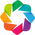

In [10]:
hv.extension("bokeh")

Let's define keyword arguments that will be commonly used for all of the plots and their `opts` throughout. For that, the plotting arguments are `aggregator=mean` to use the average of node values for shading in the rasterization and `precompute=True` to cache the data internally; the `opts` arguments are nothing more than opting in to showing the colorbar and using a colormap called "coolwarm":

In [11]:
plot_kwargs = {
    "aggregator": "mean",
    "precompute": True,
}

opts_kwargs = {
    "colorbar": True,
    "cmap": "coolwarm",
}

### Holoviews' options system: `opts`

HoloViz packages provide high-level visualization functions that allow the customization of plot features through optional arguments. Furthermore, the HoloViews options system allows customizing a plot from title to size, legend, axes, and more. This system works by calling the `.opts()` method through a HoloViews plot object. We will set the `opts` defaults below and then customize plots throughout the notebook via `.opts()`. Keep an eye on them!

In [12]:
opts.defaults(
    opts.Image(frame_width=600, data_aspect=1),
)

### Pan & zoom

Bokeh-rendered Holoviz plots come with default pan and zoom (box & wheel), tools as well as save and reset options in the very right. Just look at the following plot for those features, which uses Datashader's rasterization method to visualize the data.

In [13]:
rasterized = hds_rasterize(trimesh, **plot_kwargs)
rasterized.opts(**opts_kwargs) * gf.coastline(projection=projection)

:DynamicMap   []
   :Overlay
      .Image.I     :Image   [x,y]   (x_y z)
      .Coastline.I :Feature   [Longitude,Latitude]

### Hover

Use `tools=['hover']` can be used to get the plot to display data values while hovering over the plot (there are other tools that can be selected, too, but those will not be covered in this notebook). See the below plot (let's use the dual mesh data this time just for the sake of assortment of visualizations) and hover you cursor over it:

In [16]:
rasterized = hds_rasterize(trimesh_dual, **plot_kwargs)
rasterized.opts(tools=["hover"], clim=(-4e-4, 4e-4), **opts_kwargs) * gf.coastline(
    projection=projection
)

:DynamicMap   []
   :Overlay
      .Image.I     :Image   [x,y]   (x_y z)
      .Coastline.I :Feature   [Longitude,Latitude]

### Dynamic plot

You can decide whether to return a dynamic plot that sends updates on widget and zoom/pan 
events or whether all the data should be embedded by using the boolean `dynamic` argument. 
The default value of this argument is `True`, so all the previously rendered plots were 
already dynamic. 

:::{warning}
If you are looking at this through the Pythia Cookbook gallery webpage (i.e. this is a rendered notebook as html), you cannot experience how the "dynamic" option works. To do that, you have to execute the notebook live (e.g. through the Binder link we provide for the cookbook or by executing it in your local).
:::

Now let's look at a non-dynamic plot (i.e. `dynamic=False`):

In [ ]:
rasterized = hds_rasterize(trimesh, **plot_kwargs, dynamic=False)
rasterized.opts(**opts_kwargs) * gf.coastline(projection=projection)

:::{tip}
This plot does not look immediately different than the prior ones where `dynamic=True`, right? Yes, in the global view, but try zooming into the plot (again, if you are executing notebook rather than looking at the rendered one), and see how dynamic vs. non-dynamic plots look like. See the below comparison for instance:
:::

Non-Dynamic-Zoomed             |  Dynamic-Zoomed
:-------------------------:|:-------------------------:
![non-dynamic-zoomed](images/hv-non-dynamic-zoomed.png)  |  ![dynamic-zoomed](images/hv-dynamic-zoomed.png)

### Further interactivity considerations

Even though we will not cover in the scope of this cookbook, you may want to have a look at the following Holoviz resources for further interactivity in your plots:

- [Mandelbrot](https://holoviews.org/gallery/apps/bokeh/mandelbrot.html)
- [Player](https://holoviews.org/reference/apps/bokeh/player.html)
- [HoloMap](https://holoviews.org/reference/containers/bokeh/HoloMap.html)

## Summary

Holoviz technologies can be used in order to create interactive plots when Bokeh is used as the backend. Even though a really large dataset (e.g. km-scale) is not 
showcased in this notebook, Holoviz packages are reasonably performant with visualization of such data, too.

### What's next?

The end of this notebook wraps up this cookbook as well. Thanks for reading!


## Resources and references

- [MPAS Mesh Specification](https://mpas-dev.github.io/files/documents/MPAS-MeshSpec.pdf) for those interested